# 📝 Relatório de Detecção de Outliers Utilizando DBSCAN

## 🔍 Objetivo
Identificar anomalias e outliers no dataset fornecido, utilizando o algoritmo de clustering baseado em densidade, DBSCAN. A análise será enriquecida com visualizações geradas a partir de uma redução de dimensionalidade com PCA, facilitando a interpretação dos clusters e dos pontos considerados outliers.

In [2]:
import pandas as pd

df = pd.DataFrame(pd.read_pickle('x_scaled.pickle'))
print(df.shape)
df.head()


(3100, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.833333,0.019103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.666667,0.126231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.666667,0.178560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,0.344442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.333333,0.008637,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [2]:
%pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Dimensões do dataset: (3100, 17)


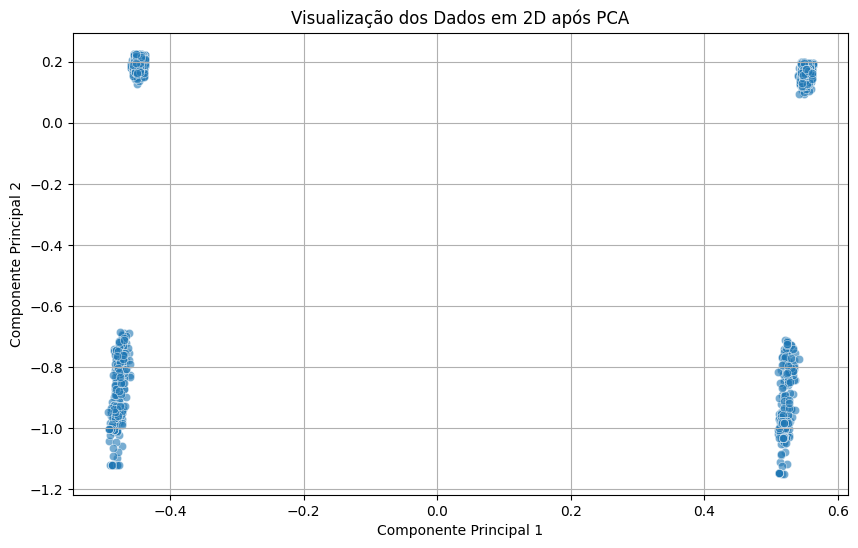

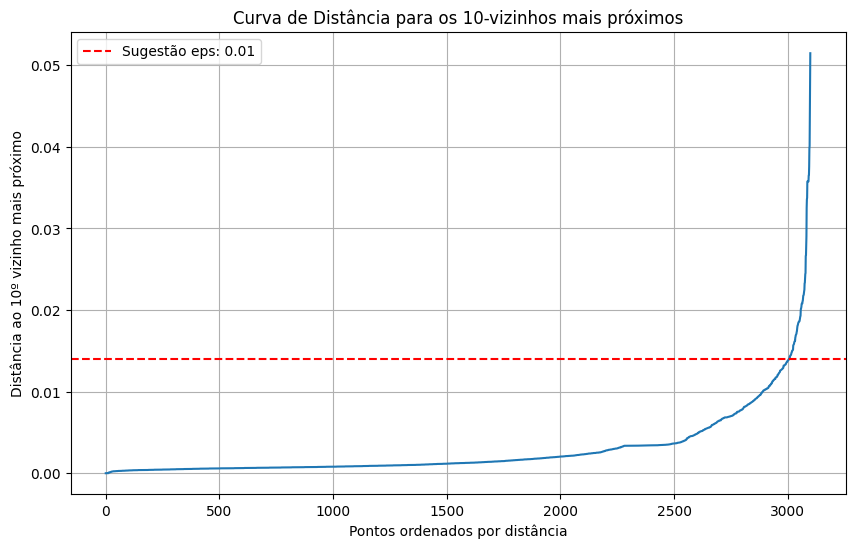


Valor sugerido para eps: 0.0140

Contagem de pontos por cluster:
cluster
-1      41
 0    1173
 1     120
 2    1400
 3     139
 4      95
 5     110
 6      12
 7      10
Name: count, dtype: int64


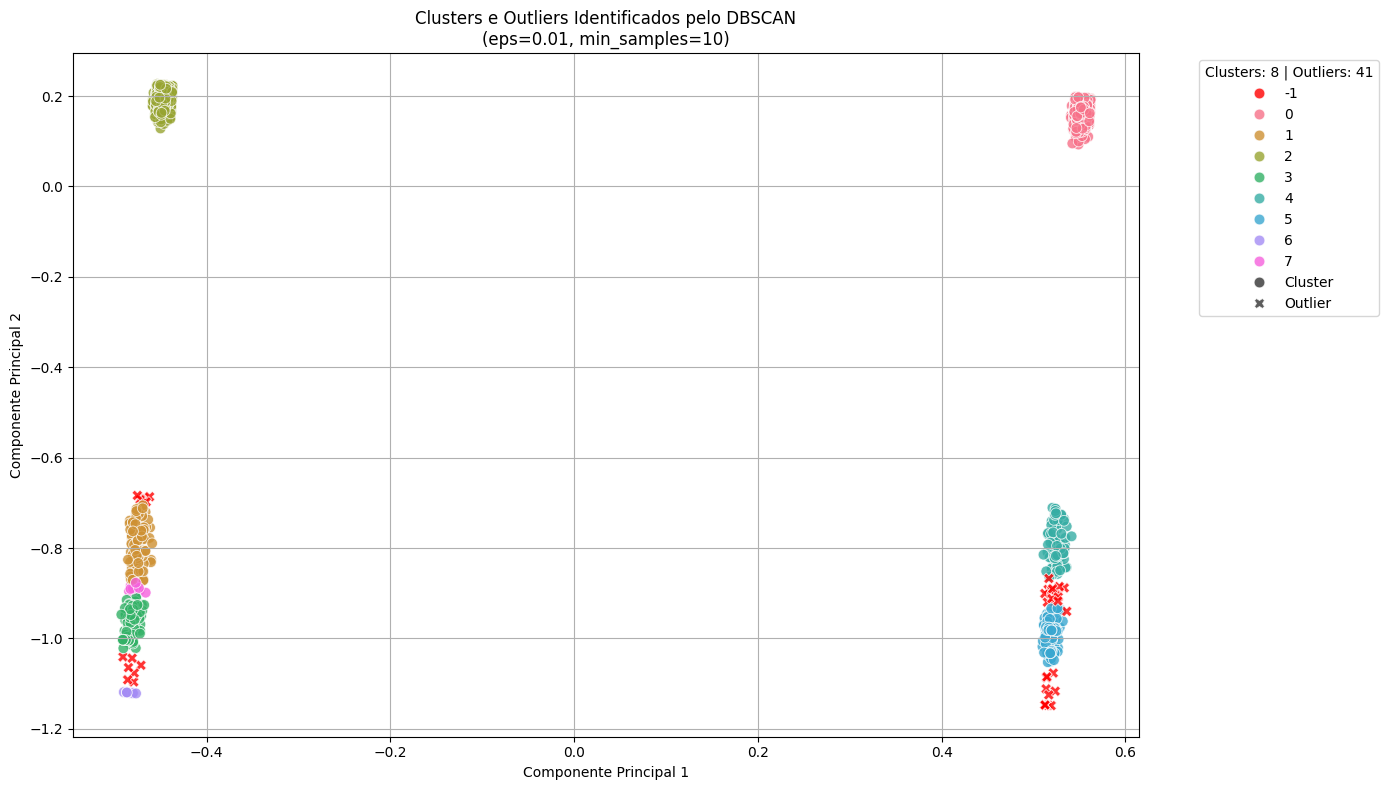


Número de outliers detectados: 41

Estatísticas descritivas dos outliers:
              0          1          2          3          4          5   \
count  41.000000  41.000000  41.000000  41.000000  41.000000  41.000000   
mean    0.512195   0.565845   0.682927   0.024390   0.024390   0.097561   
std     0.236849   0.354800   0.471117   0.156174   0.156174   0.300406   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.333333   0.348271   0.000000   0.000000   0.000000   0.000000   
50%     0.500000   0.664547   1.000000   0.000000   0.000000   0.000000   
75%     0.666667   0.869910   1.000000   0.000000   0.000000   0.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              6          7     8          9     10    11    12         13  \
count  41.000000  41.000000  41.0  41.000000  41.0  41.0  41.0  41.000000   
mean    0.024390   0.560976   0.0   0.024390   0.0   0.0   0.0   0.097561   
std     0.156174  

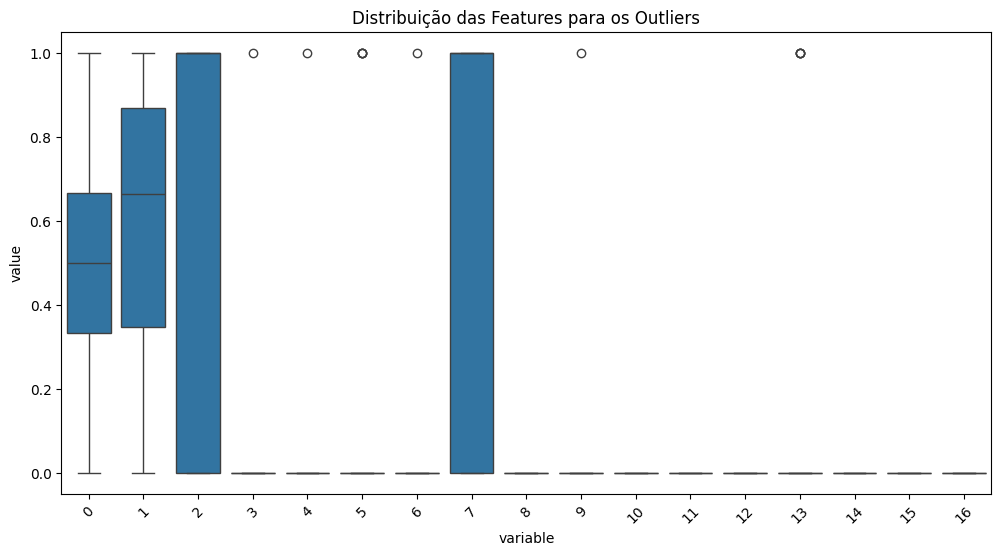

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1. Carregar os dados
df = pd.DataFrame(pd.read_pickle('x_scaled.pickle'))
print("Dimensões do dataset:", df.shape)

# 2. Redução de dimensionalidade com PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# 3. Visualização inicial após PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', alpha=0.6)
plt.title('Visualização dos Dados em 2D após PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# 4. Determinação dos parâmetros do DBSCAN (eps)
def find_optimal_eps(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, _ = nbrs.kneighbors(data)
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f'Curva de Distância para os {k}-vizinhos mais próximos')
    plt.xlabel('Pontos ordenados por distância')
    plt.ylabel(f'Distância ao {k}º vizinho mais próximo')
    plt.grid(True)
    
    # Adicionando linha para sugerir o valor de eps
    eps_suggestion = np.percentile(distances, 97) 
    plt.axhline(y=eps_suggestion, color='r', linestyle='--', 
                label=f'Sugestão eps: {eps_suggestion:.2f}')
    plt.legend()
    
    plt.show()
    
    return eps_suggestion

# Encontrar eps ideal (k=min_samples)
min_samples = 10
eps = find_optimal_eps(df_pca, k=min_samples)
print(f"\nValor sugerido para eps: {eps:.4f}")

# 5. Aplicação do DBSCAN com parâmetros otimizados
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(df_pca)

# Adicionar rótulos ao dataframe PCA
df_pca['cluster'] = clusters

# Contagem de pontos por cluster
cluster_counts = df_pca['cluster'].value_counts().sort_index()
print("\nContagem de pontos por cluster:")
print(cluster_counts)

# 6. Visualização dos clusters e outliers
plt.figure(figsize=(14, 8))

# Criar paleta de cores (outliers em vermelho)
n_clusters = len(cluster_counts) - 1  # Excluindo os outliers (-1)
palette = sns.color_palette("husl", n_clusters)
palette.insert(0, (1, 0, 0))  # Vermelho para outliers

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', 
                palette=palette, alpha=0.8, s=60, 
                style=df_pca['cluster'].apply(lambda x: 'Outlier' if x == -1 else 'Cluster'),
                markers={'Outlier': 'X', 'Cluster': 'o'})

plt.title(f'Clusters e Outliers Identificados pelo DBSCAN\n(eps={eps:.2f}, min_samples={min_samples})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
           title=f'Clusters: {n_clusters} | Outliers: {sum(clusters == -1)}')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Análise detalhada dos outliers
if -1 in clusters:
    outliers = df[clusters == -1]
    print(f"\nNúmero de outliers detectados: {len(outliers)}")
    print("\nEstatísticas descritivas dos outliers:")
    print(outliers.describe())
    
    # Visualização da distribuição dos outliers no espaço original
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=outliers.melt(), x='variable', y='value')
    plt.title('Distribuição das Features para os Outliers')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("\nNenhum outlier detectado com os parâmetros atuais.")



from sklearn.decomposition import PCA

# Manter componentes que capturam 95% da variância
pca = PCA(n_components=0.95)
df_reduced = pca.fit_transform(df)

In [3]:
from sklearn.cluster import DBSCAN
import numpy as np

# Aplicar DBSCAN com os parâmetros sugeridos
dbscan = DBSCAN(eps=0.0115, min_samples=10)  # Valores otimizados
clusters = dbscan.fit_predict(df_pca)

# Contar clusters e outliers
unique_clusters = np.unique(clusters)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
n_outliers = sum(clusters == -1)

print(f"Clusters encontrados: {n_clusters}")
print(f"Outliers encontrados: {n_outliers}")

# Análise detalhada
print("\nDistribuição dos pontos por cluster:")
for cluster in unique_clusters:
    if cluster == -1:
        print(f"Outliers (cluster -1): {sum(clusters == -1)} pontos")
    else:
        print(f"Cluster {cluster}: {sum(clusters == cluster)} pontos")

Clusters encontrados: 10
Outliers encontrados: 79

Distribuição dos pontos por cluster:
Outliers (cluster -1): 79 pontos
Cluster 0: 1171 pontos
Cluster 1: 92 pontos
Cluster 2: 1399 pontos
Cluster 3: 138 pontos
Cluster 4: 73 pontos
Cluster 5: 105 pontos
Cluster 6: 12 pontos
Cluster 7: 14 pontos
Cluster 8: 10 pontos
Cluster 9: 7 pontos
